# Value-at-Risk

## Import Libraries

In [246]:
import numpy as np
import pandas as pd
import requests
from dateutil import relativedelta
from scipy.stats import t
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Risk Free Rate 
RF = 0.05
CONF_LEVEL = 95
TIME_HORIZEN = 1

### Historical Data Aquisition

In [195]:
def get_alphavantagekey(path):
    with open(path) as f:
        key  = f.read().strip()
    return key
KEY=get_alphavantagekey('keys/alphavantage.txt')

### Base Class

In [196]:
class FinancialInstrument:
    def __init__(self, name:str, identifier:str, conf_level:float, time_horizen:int):
        self.name = name
        self.identifier = identifier
        self.conf_level = conf_level
        self.time_horizen = time_horizen
        self.prices = None
        self.returns = None
        self.total_return = None
        self.mu = None
        self.sigma = None
        self.histVaR = None
        self.histCVaR = None

    def __str__(self):
        txt = f"{self.name} ({self.identifier})\n"
        txt += "="*100 + '\n'
        return txt

    def calc_HistVaR(self):
        """Historical Value-at-Risk for a confidence interval"""
        VaR = np.percentile(self.returns,100-self.conf_level) * np.sqrt(self.time_horizen)
        return VaR

    def calc_HistCVaR(self):
        """
        Historical Conditional Value-at-Risk for a confidence interval
        Find the average of the worst returns below the VaR
        """
        below_var = self.returns <= self.histVaR
        CVaR = self.returns[below_var].mean() * np.sqrt(self.time_horizen)
        return CVaR

    def plot_prices(self):
        df = self.prices
        hover_temp = "Date:%{x}"+ " Closing Price:%{y:,.0f}"
        title = f"<b>{self.name} ({self.identifier})</b><br>Return: {self.mu*100:.2f}% | Volatility: {self.sigma*100:.2f}% | TR:{self.total_return*100:.2f}%"
        fig = go.Figure(
            go.Scatter(
                x = df.index,
                y = df.close,
                line = dict(color = 'rgb(83,128,141)',width=2),
                fill='tozeroy',
                fillcolor = 'rgba(83,128,141,0.5)',
                hovertemplate = hover_temp
            )
        )
        fig.update_layout(
            template='plotly_white',
            title = title,
            yaxis_title='Closing Price' ,
            width=600, height=500
        )
        fig.show()

    def plot_histograms(self):
        """"Plot the histogram of daily returns with VaR"""

        title = f"<b>{self.name} Historical VaR ({self.time_horizen} days) </b><br>VaR:{self.histVaR*100:.2f}% | CVaR: {self.histCVaR*100:.2f}%"
        returns = self.returns *100
        min_r = min(self.returns)*100
        max_r = max(self.returns)*100

        # histogram
        fig = go.Figure(
            go.Histogram(
                x = returns,
                marker_color = 'rgba(83,128,141,0.8)'
            )
        )
        # CVaR Area
        fig.add_shape(
            type='rect',
            x0=min_r,
            x1= self.histVaR*100,
            y0=0,
            y1=1,
            fillcolor='red',
            opacity=0.1
        )
        # Non-CVaR Area
        fig.add_shape(
            type='rect',
            x1=max_r,
            x0= self.histVaR*100,
            y0=0,
            y1=1,
            fillcolor='skyblue',
            opacity=0.1
        )
        # VaR threshold
        fig.add_shape(
            type='line',
            x1=self.histVaR *100,
            x0= self.histVaR*100,
            y0=0,
            y1=1,
            line=dict(color='rgba(255,51,51,.5)'),
        )

        # VaR Threshold
        fig.add_annotation(
            x=self.histVaR*100,
            y=0.8,
            xref='x',
            yref='paper',
            text = "VaR<br>Threshold",
            ax=100,
            font = dict(size=14,color='rgba(255,51,51,0.8)'),
            bordercolor = 'rgba(255,51,51,.2)',
            bgcolor = 'rgba(255,51,51,.2)',
            arrowcolor = 'rgba(255,51,51,.5)',
            showarrow=True,
            arrowhead=4
        )
        # CVaR Area
        fig.add_annotation(
            x=self.histVaR*100,
            y=0.5,
            xref='x',
            yref='paper',
            text = "CVaR<br>Area",
            ax=-40,
            font = dict(size=14,color='rgba(255,51,51,0.8)'),
            arrowcolor = 'rgba(255,51,51,.5)',
            showarrow=True,
            arrowhead=4
        )
        fig.update_layout(template = 'plotly_white',width=600, height=500, title=title)
        fig.update_shapes(dict(xref='x',yref='paper'))
        fig.show()

### Security Class

In [197]:
class Security(FinancialInstrument):
    def __init__(self, name, identifier, conf_level, time_horizen,key:str):
        super().__init__(name, identifier, conf_level, time_horizen)
        self.key = key

    def __str__(self):
        """Print Security Attributes"""
        # inherited attributes
        txt = super().__str__()

        try:
            # calcualte the lenght of historical daily data
            from_ = min(self.prices.index).date()
            to_ = max(self.prices.index).date()
            datediff = relativedelta.relativedelta(to_,from_)

            if datediff.years > 1:
                freq = f"{datediff.years:.0f} Years, {datediff.months:.0f} Months"
            else:
                freq = f"{datediff.days} days"
        
            # print message
            txt += f"Date Range:{from_} - {to_} ({freq})\n"
            txt += f"Total Return: {self.total_return*100:.2f}%\n"
            txt += f"Annualized Return: {self.mu*100:.2f}% | Annualized Volatility: {self.sigma*100:.2f}%\n"
            txt += f"Historical VaR ({self.time_horizen} days): {self.histVaR*100:.2f}% | Historical CVaR: {self.histCVaR*100:.2f}%\n"
        except:
            txt += "=> Get historical returns or simulate returns"
        return txt

    
    def get_historical_price_data(self):
        """
        Returns daily data for a stock (symbol)
        key: api key
        symbols: VMW,AAPL,GOOG,SPY
        """
        def calc_return(returns):
            """ calculate annualized return from daily returns"""
            return np.prod(1 + returns) ** (252/len(returns)) - 1
        def calc_volatility(returns):
            """calculate annualized volatilit from daily returns"""
            return np.std(returns) * np.sqrt(252)
        def calc_total_return(self):
            """calculate the total return for the period"""
            index_first = self.prices.index[0]
            index_last = self.prices.index[-1]
            return self.prices.loc[index_last,'close'] / self.prices.loc[index_first, 'close'] -1

        # request data from alphavantage
        url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={self.identifier}&apikey={self.key}&outputsize=full"
        r = requests.get(url)
        d = r.json()

        # extract data to a df
        df = pd.DataFrame(d['Time Series (Daily)']).T
        df.columns = ['open','high','low','close','volume']
        df['symbol'] = self.identifier

        # change data types
        df.index = pd.to_datetime(df.index)
        df = df.sort_index()

        # convert datatype to float
        for col in ['open','high','low','close','volume']:
            df[col] = df[col].astype('float')

        # calc daily returns
        df['returns'] = df['close'].pct_change()

        # update the security attributes
        self.prices = df
        self.returns = np.array(df['returns'].dropna())
        self.mu = calc_return(self.returns)
        self.sigma = calc_volatility(self.returns)
        self.total_return = calc_total_return(self)
        self.histVaR = super().calc_HistVaR()
        self.histCVaR = super().calc_HistCVaR()
       

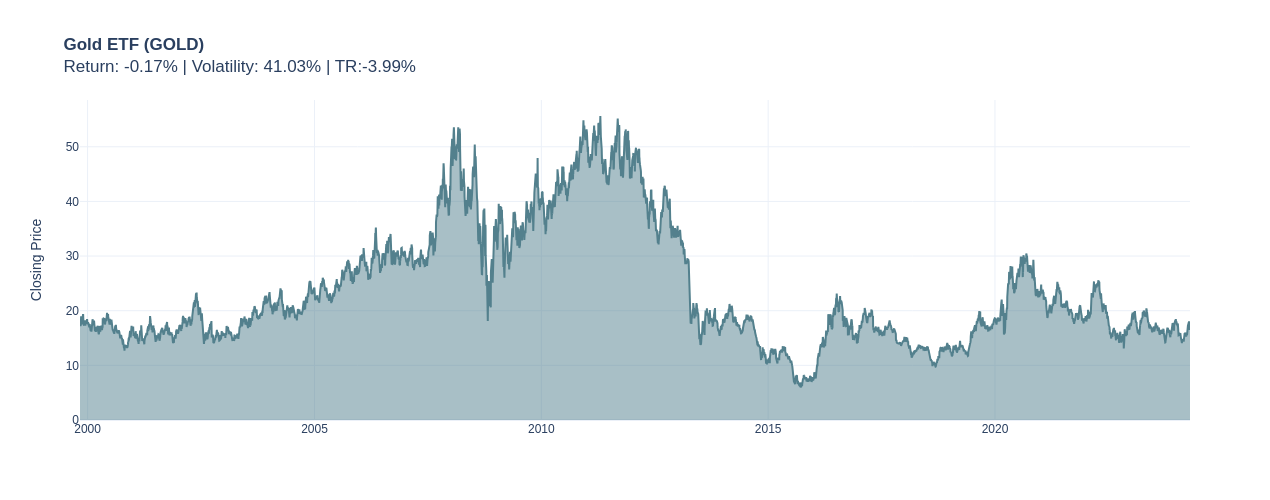

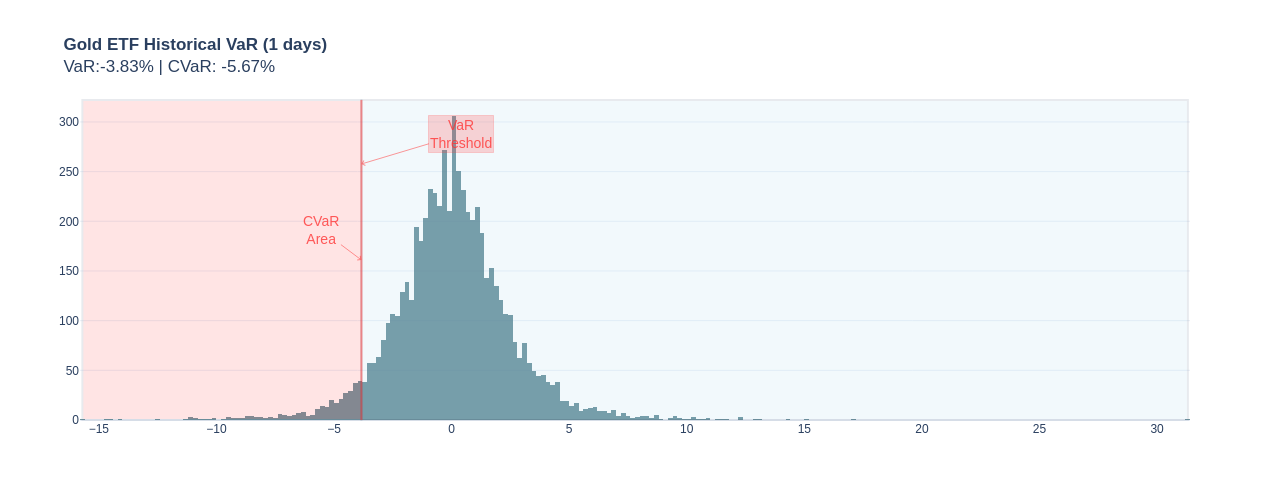

In [198]:
g = Security(
    name ='Gold ETF',
    identifier ='GOLD',
    key = KEY,
    conf_level = CONF_LEVEL, 
    time_horizen = TIME_HORIZEN
)

# get historical data
g.get_historical_price_data()

# plots
g.plot_prices()
g.plot_histograms()

S&P500 (SPY)
Date Range:1999-11-01 - 2024-04-19 (24 Years, 5 Months)
Total Return: 265.26%
Annualized Return: 5.45% | Annualized Volatility: 19.54%
Historical VaR (1 days): -1.92% | Historical CVaR: -2.95%



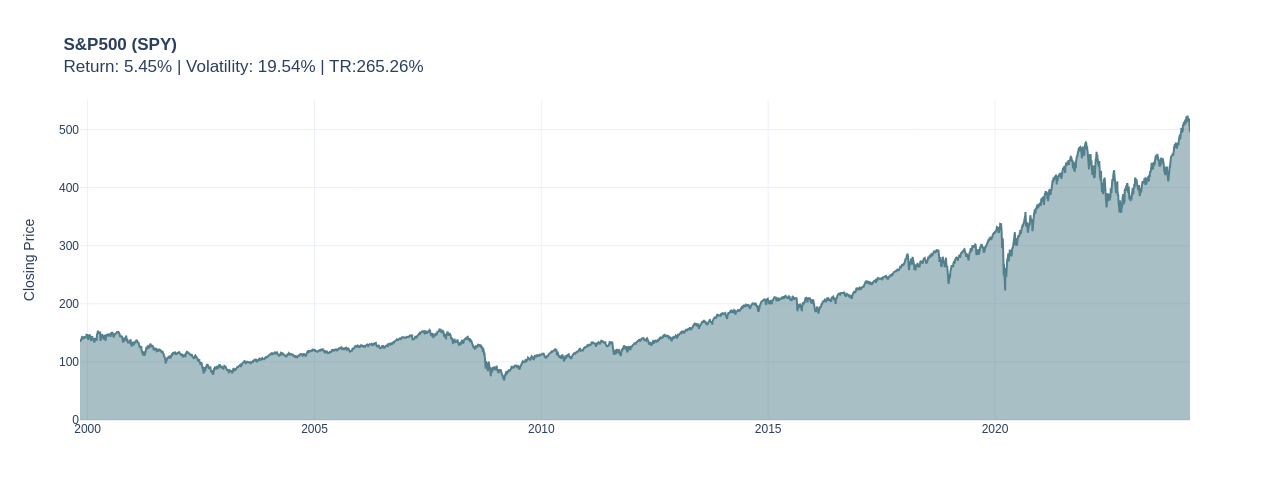

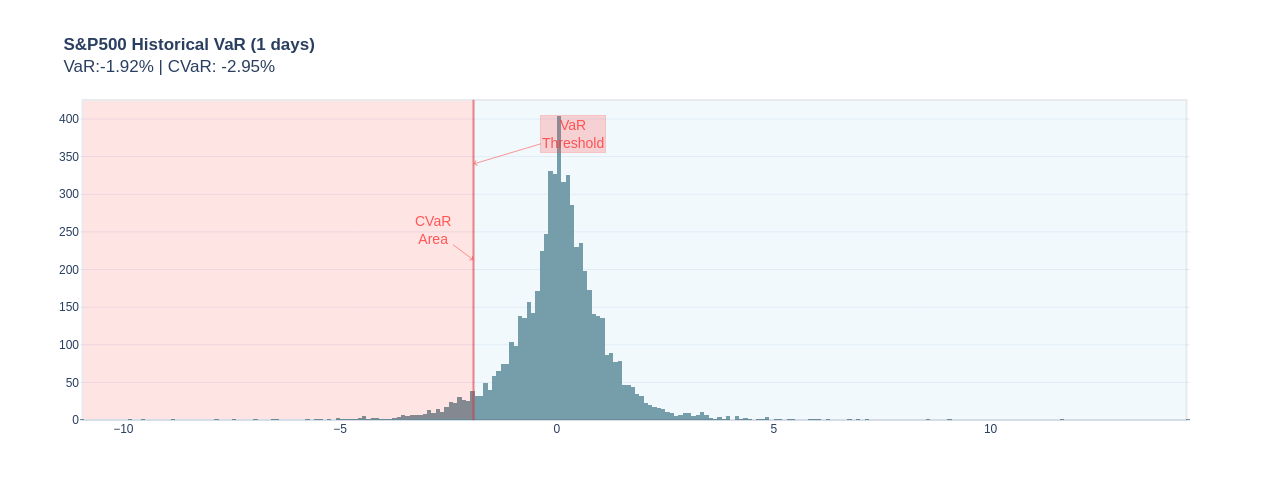

In [199]:
# Security 
s = Security(
    name ='S&P500',
    identifier ='SPY',
    key = KEY,
    conf_level = CONF_LEVEL, 
    time_horizen = TIME_HORIZEN
)

# get historical data
s.get_historical_price_data()

# plots
print(s)
s.plot_prices()
s.plot_histograms()


### Portfolio Class

Equity Portfolio (PORT1)
Initial Value: $100,000
Portfolio Holdings:
----------------------------------------------------------------------------------------------------
  + S&P500(80.00%) | Return:5.45% | Volatility:19.54%
  + Gold ETF(20.00%) | Return:-0.17% | Volatility:41.03%

Historical Portfoio Performance
----------------------------------------------------------------------------------------------------
Total Return 297.46% | Annualized 4.62% | Volatility:18.89%
Value-at-Risk (1 days): -1.78%
Conditional Value-at-Risk (1 days): -2.78%



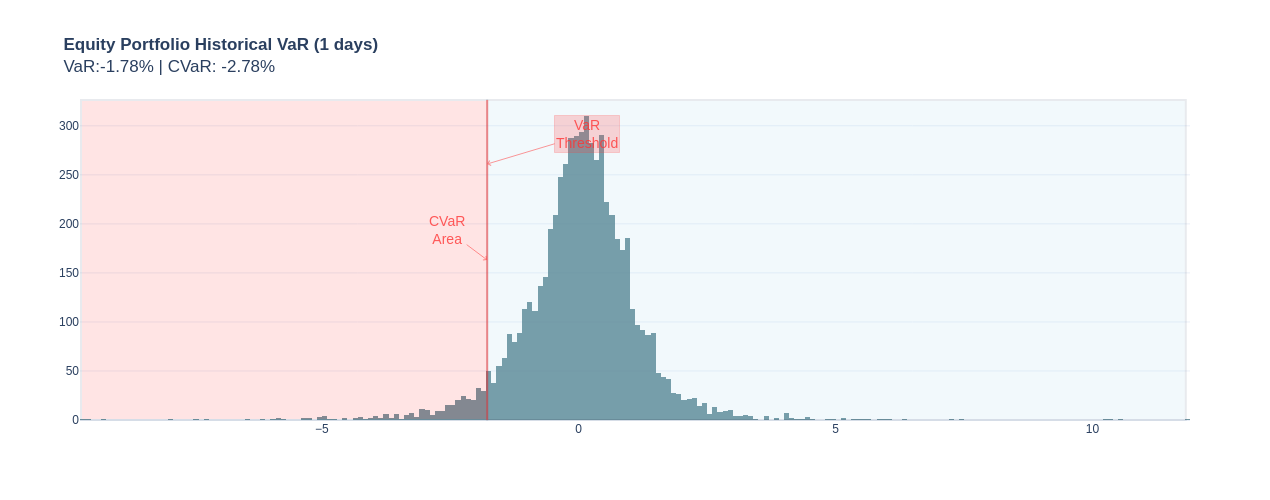

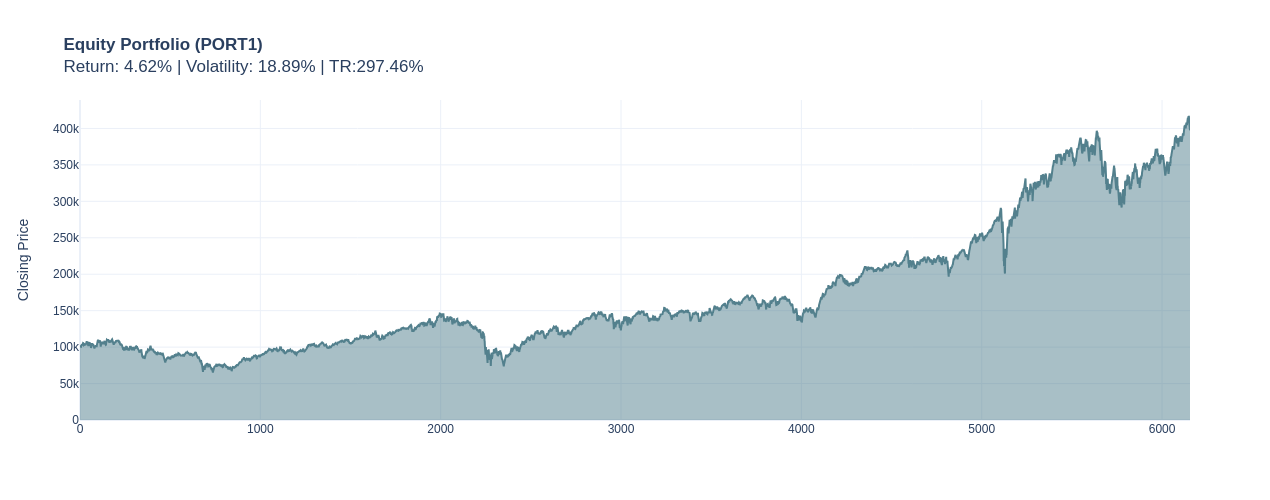

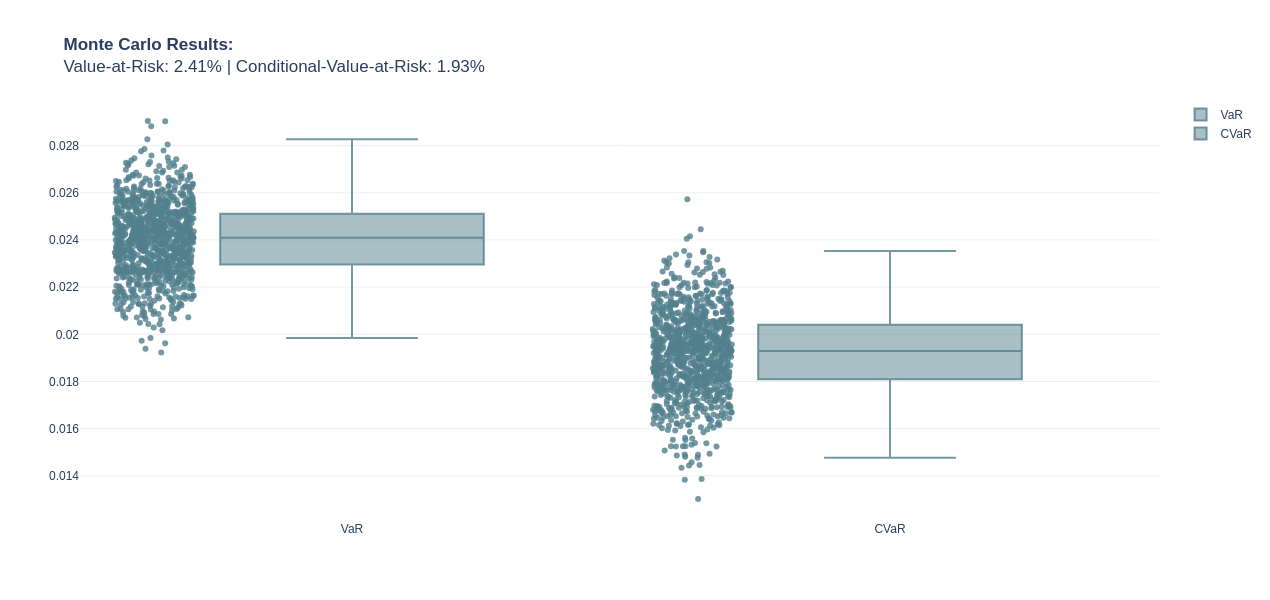

In [299]:
class Portfolio(FinancialInstrument):
    def __init__(self, name, identifier, conf_level, time_horizen, initial_value, securities, weights):
        super().__init__(name, identifier, conf_level, time_horizen)
        self.initial_value = initial_value
        self.securities = securities
        self.weights = weights
        self.mc_results = None
        # self.mc_results = {'total_return':[],'return':[],'volatility':[],'VaR':[],'CVaR':[]}

    def __str__(self):
        txt = super().__str__()
        txt += f"Initial Value: ${self.initial_value:,.0f}\n"
        txt += "Portfolio Holdings:\n"
        txt += "-"*100 + "\n"
        for i, security in enumerate(self.securities):
            txt += f"  + {security.name}({self.weights[i]*100:.2f}%) | Return:{security.mu*100:.2f}% | Volatility:{security.sigma*100:.2f}%\n"
        txt += "\nHistorical Portfoio Performance\n"
        txt += "-"*100 + "\n"
        txt += f"Total Return {self.total_return*100:.2f}% | Annualized {self.mu*100:.2f}% | Volatility:{self.sigma*100:.2f}%\n"
        txt += f"Value-at-Risk ({self.time_horizen} days): {self.histVaR*100:.2f}%\n"
        txt += f"Conditional Value-at-Risk ({self.time_horizen} days): {self.histCVaR*100:.2f}%\n"
        return txt

    def calc_covariance(self):
        for i,sec in enumerate(self.securities):
            r = pd.DataFrame(sec.prices['returns'])
            r.columns = [f'returns_{sec.identifier}']
            if i==0:
                df_r = r
            else:
                df_r = df_r.join(r, how='inner',lsuffix=f'_{sec.identifier}')
        # update the cov matrix for the portfolio
        return df_r.cov()

    def calc_portfolio_values(self):
        """ """ 
        # extract historical security returns
        sec_returns = []
        for sec in self.securities:
            sec_returns.append(sec.returns)

        # transpose
        sec_returns = np.array(sec_returns).T

        # calculate the weight portfolio return
        p_returns = sec_returns.dot(self.weights)

        # calculate portfolio values
        p_values = np.cumprod(1 + p_returns) * self.initial_value
        p_values = np.insert(p_values, 0, self.initial_value)

        # calculate returns
        p_total_return = (1+p_returns).prod()-1
        p_return  = p_total_return ** (255/len(p_returns)) -1
        p_vol = np.std(p_returns) *  np.sqrt(255)

        # update portfolio attributes
        self.total_return = p_total_return
        self.prices = pd.DataFrame({'close':p_values})
        self.mu = p_return
        self.sigma = p_vol
        self.returns = p_returns
        self.histVaR = super().calc_HistVaR()
        self.histCVaR = super().calc_HistCVaR()

    
    def run_monte_carlo(self, num_sims, num_days):
            """
            num_sims: number of simulations to run
            num_days: number of days in each simulation
            """

            # results accumulator
            results = []
    
            # initial holdings
            portfolio = np.array([w*self.initial_value for w in self.weights])

            # calculate the convariance amoung securities
            self.cov = self.calc_covariance()
            
            # loop through simulations
            for sim in range(num_sims):    
                # simulation results
                result = {      
                    'portfolio-returns':None,
                    'portfolio-values':None,
                    'portfolio-return':None,
                    'portfolio-std':None,
                    'portfolio-var':None,
                    'portfolio-cvar': None,
                }
    
                # simulate multivariate returns for each security
                sec_mu = [m.mu for m in self.securities] 
                sec_returns = np.random.default_rng().multivariate_normal(sec_mu, np.array(self.cov), num_days).T

                # transform the security returns
                sec_returns = np.array(sec_returns).T
     
                # calc the weighted portfolio returns
                p_returns = sec_returns.dot(self.weights)
    
                # calc portfolio value
                p_values = np.cumprod(p_returns + 1)*self.initial_value
            
                # cumulative portfolio return
                p_cr = (p_returns + 1).prod()-1

                # annualized portfolio return
                p_ret = (1 + p_cr)**(num_days / 252)-1
                
                # annualized portfolio standard deviation
                p_std = np.std(p_returns) * np.sqrt(252)

                # update the portfolio returns
                self.returns = p_returns

                # calculate the var
                var = super().calc_HistVaR()
                self.histVaR = var

                # calculate the CVaR
                cvar = super().calc_HistCVaR()
                self.histCVaR = cvar
                
                # accumulate data summaries
                result['portfolio-return'] = p_ret
                result['portfolio-std'] = p_std 
                result['portfolio-var'] = var
                result['portfolio-cvar'] = cvar
                result['portfolio-returns'] = p_returns
                result['portfolio-values'] = np.insert(p_values,0,self.initial_value)

                # accumulate simulation summary
                results.append(result)
                
            # update the simulation results
            self.mc_results = results

    def plot_vars(self):
        """"""
        # get the VaR, median VaR
        vars = [sim['portfolio-var'] for sim in self.mc_results]
        med_var = np.median(vars) *100

        # get the CVaRs, median CVaR
        cvars = [sim['portfolio-cvar'] for sim in self.mc_results]
        med_cvar = np.median(cvars) *100

        # plot
        title = f"<b>Monte Carlo Results:</b><br>"
        title += f"Value-at-Risk: {med_var:.2f}% | Conditional-Value-at-Risk: {med_cvar:.2f}%"
        
        fig = go.Figure()
        fig.add_trace(
            go.Box(
                y=vars,
                name='VaR',
                marker_color = 'rgba(83,128,141,0.8)',
                boxpoints='all'
            )
        )
        fig.add_trace(
            go.Box(
                y=cvars,
                name='CVaR',
                marker_color = 'rgba(83,128,141,0.8)',
                boxpoints='all'
            )
        )
        
        fig.update_layout(height=600,width=500,template='plotly_white',title=title)
        fig.show()








        
# Portfolio
portfolio = Portfolio(
    name = 'Equity Portfolio', 
    identifier = 'PORT1',
    securities= [s,g],
    weights = [0.80, 0.20],
    initial_value = 100000,
    conf_level = CONF_LEVEL,
    time_horizen = TIME_HORIZEN,
)

# calculate portfolio values
portfolio.calc_portfolio_values()
print(portfolio)

portfolio.plot_histograms()
portfolio.plot_prices()

# run monte carlo simulation
portfolio.run_monte_carlo(1000,252)

# plot Vars
portfolio.plot_vars()

## Variance/Covariance Value-at-Risk

## Conditional Value-at-Risk